### Optimization of 2-D Rosenbrock function for varied coefficients

Reference: https://en.wikipedia.org/wiki/Rosenbrock_function

$$ cost(a,b,x,y) =  b (y-x)^2 + (x-a)^2 ,$$
$$pdf(a,b,x,y) = e^{-cost(a,b,x,y)}$$ 

Here, $\mathbf{x}_{task}=(a,b)$ and $\mathbf{x}_{decision} = (x,y)$

The global optima is unique: $(a,a^2)$

We show that TTGO is able to find the global optima consistently with a hand few of samples from the constructed tt-model of the above pdf (constructed offline) for various selection of $\mathbf{x}_{task}$ in the online phase.  We use scipy's SLSQP to fine tune the initialization. 

Condition on different values of $\mathbf{x}_{task}=(a,b)$ to test the model.

Copyright (c) 2008 Idiap Research Institute, http://www.idiap.ch/
    Written by Suhan Shetty <suhan.shetty@idiap.ch>,


In [1]:
import torch
import numpy as np
import sys
sys.path.append('./fcn_opt')
sys.path.append('../')

from ttgo import TTGO
import tt_utils
from test_fcns import Rosenbrock_4D 
from fcn_plotting_utils import plot_surf, plot_contour

%load_ext autoreload
np.set_printoptions(precision=3)
%autoreload 2

/idiap/temp/sshetty/miniconda/envs/pyml/lib/python3.9/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
Matplotlib created a temporary config/cache directory at /tmp/matplotlib-g_iq2gi6 because the default path (/idiap/home/sshetty/.cache/matplotlib) is not a writable directory; it is highly recommended to set the MPLCONFIGDIR environment variable to a writable directory, in particular to speed up the import of Matplotlib and to better support multiprocessing.


In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

### Define the function

In [3]:
pdf, cost =  Rosenbrock_4D(alpha=1)

### Define the domain and the discretization

In [4]:
# Define the domain of the function

L = 2 # [-L,L]^2 is the domain of the function

# domain of task params: domain of coefficients a and b in Rosenbrock_4D
# Note: a should in (-sqrt(L), sqrt(L)) 
domain_task = [torch.linspace(-1.5,1.5,500).to(device)]+[torch.linspace(50,150,500).to(device)] 
# domain of decison varibales
domain_decision = [torch.linspace(-L,L,500).to(device)]*2
domain = domain_task+domain_decision

In [5]:
# Find the tt-model corresponding to the pdf
tt_model = tt_utils.cross_approximate(fcn=pdf,  domain=domain, 
                        rmax=200, nswp=20, eps=1e-3, verbose=True, 
                        kickrank=5, device=device)

cross device is cuda
Cross-approximation over a 4D domain containing 6.25e+10 grid points:
iter: 0  | tt-error: 1.001e+00, test-error:9.015e-01 | time:   1.2064 | largest rank:   1
iter: 1  | tt-error: 1.777e+00, test-error:7.004e-01 | time:   1.2327 | largest rank:   6
iter: 2  | tt-error: 5.191e-01, test-error:6.113e-01 | time:   1.2664 | largest rank:  11
iter: 3  | tt-error: 4.472e-01, test-error:4.940e-01 | time:   1.3152 | largest rank:  16
iter: 4  | tt-error: 1.785e-01, test-error:4.519e-01 | time:   1.3964 | largest rank:  21
iter: 5  | tt-error: 2.482e-01, test-error:3.744e-01 | time:   1.5070 | largest rank:  26
iter: 6  | tt-error: 1.705e-01, test-error:3.040e-01 | time:   1.6571 | largest rank:  31
iter: 7  | tt-error: 1.760e-01, test-error:2.437e-01 | time:   1.8881 | largest rank:  36
iter: 8  | tt-error: 1.815e-01, test-error:1.875e-01 | time:   2.1445 | largest rank:  41
iter: 9  | tt-error: 1.319e-01, test-error:1.109e-01 | time:   2.4971 | largest rank:  46
iter: 10 

### Fit the TT-Model

In [6]:
ttgo = TTGO(tt_model=tt_model,domain=domain,cost=cost,device=device)

### Sample from TT-Model

In [7]:
x_task = torch.tensor([0.25,140.]).view(1,-1).to(device) #given task-parameters
n_samples_tt = 100
samples = ttgo.sample_tt(n_samples=n_samples_tt, x_task=x_task.view(1,-1), alpha=0.75) 

### Choose the best sample as an estimate for optima

In [8]:
best_estimate = ttgo.choose_best_sample(samples)[0]
ttgo_optimized, _ = ttgo.optimize(best_estimate)

##### Fine-tune the estimate using gradient-based optimization

In [9]:
print("PDF at the estimated point: ", pdf(best_estimate))
print("PDF at the optima: ", pdf(ttgo_optimized))

PDF at the estimated point:  tensor([0.9973], device='cuda:0')
PDF at the optima:  tensor([1.0000], device='cuda:0')


In [10]:
print("Estimated Optima: ", best_estimate)
print("Optima: ", ttgo_optimized)

Estimated Optima:  tensor([[2.5000e-01, 1.4000e+02, 2.5251e-01, 6.8136e-02]], device='cuda:0')
Optima:  tensor([[2.5001e-01, 1.4000e+02, 2.5424e-01, 6.4664e-02]], device='cuda:0')


### Visualization

In [11]:
# Redefinig the function given the coefficients
def cost_fcn(X):
    X = torch.from_numpy(X)
    X_ext = torch.empty(X.shape[0],4)
    X_ext[:,:2] = x_task
    X_ext[:,2:] = X
    return cost(X_ext.to(device)).cpu().numpy()

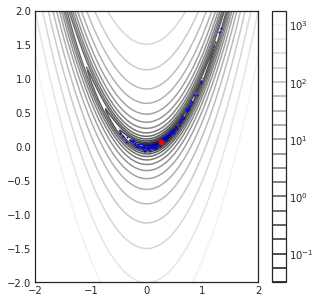

In [13]:
data = samples[0,:,2:].cpu()
x = np.linspace(-L,L,200)
y = np.linspace(-L,L,200)

plt=plot_contour(x,y,cost_fcn,data=data, contour_scale=500, figsize=5, markersize=1)
plt.plot(ttgo_optimized[:,2].cpu(),ttgo_optimized[:,3].cpu(),'.r',markersize=10)
# plt.savefig('rosenbrock4D_a25_b140_alpha0_ns1000_k1.png',pad_inches=0.01, dpi=300)
